MODEL 2 FINAL PERFORMANCE (EXPERIMENT 1).

In [1]:
### Access to google drive
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [2]:
import pandas as pd 
import cv2                 
import numpy as np         
import os                  
from random import shuffle
from tqdm import tqdm  
import scipy
import skimage
from skimage.transform import resize
import matplotlib.pyplot as plt
import tensorflow as tf

In [3]:
from keras.models import Sequential
from keras.layers import Dense , Activation
from keras.layers import Dropout
from keras.layers import Flatten
from keras.constraints import maxnorm
from keras.optimizers import SGD , RMSprop
from keras.layers import Conv2D , BatchNormalization
from keras.layers import MaxPooling2D
from keras.utils import np_utils
from keras import backend as K

Using TensorFlow backend.


In [0]:
from keras import backend as K
def weighted_categorical_crossentropy(weights):
    """
    A weighted version of keras.objectives.categorical_crossentropy
    
    Variables:
        weights: numpy array of shape (C,) where C is the number of classes
    
    Usage:
        weights = np.array([0.5,2,10]) # Class one at 0.5, class 2 twice the normal weights, class 3 10x.
        loss = weighted_categorical_crossentropy(weights)
        model.compile(loss=loss,optimizer='adam')
    """
    
    weights = K.variable(weights)
        
    def loss(y_true, y_pred):
        # scale predictions so that the class probas of each sample sum to 1
        y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
        # clip to prevent NaN's and Inf's
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        # calc
        loss = y_true * K.log(y_pred) * weights
        loss = -K.sum(loss, -1)
        return loss
    
    return loss

In [0]:
##CONFIGURATION FOR BEST MODEL 2 (EXPERIMENT 1)

from keras.optimizers import SGD , RMSprop , Adadelta , Adam
from keras.layers.normalization import BatchNormalization
from sklearn.metrics import recall_score

def weighted_pneumo_model():

  model = Sequential()
  model.add(Conv2D(16, (3, 3), activation='relu', padding="same", input_shape=(200,200,3), data_format='channels_last'))
  model.add(Conv2D(16, (3, 3), activation='relu', padding="same"))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  #model.add(BatchNormalization())

  model.add(Conv2D(32, (2, 2), activation='relu', padding="same"))
  model.add(Conv2D(32, (2, 2), activation='relu', padding="same"))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2D(64, (2, 2), activation='relu', padding="same"))
  model.add(Conv2D(64, (2, 2), activation='relu', padding="same"))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2D(128, (2, 2), activation='relu', padding="same"))
  model.add(Conv2D(128, (2, 2), activation='relu', padding="same"))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2D(256, (2, 2), activation='relu', padding="same"))
  model.add(Conv2D(256, (2, 2), activation='relu', padding="same"))
  model.add(MaxPooling2D(pool_size=(2, 2)))    

  model.add(Flatten())        


  model.add(Dense(512, activation='relu'))
  
  model.add(Dropout(0.6))
  model.add(Dense(256, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(2 , activation='softmax'))

  from sklearn import metrics
  from keras import backend as K
  from tensorflow.keras.metrics import Recall
  from keras import optimizers

  w=np.array([0.25,4])
  w_loss=weighted_categorical_crossentropy(w)
  
  model.compile(loss=w_loss,
                    # here we add a regulizer normalization function from Talos
                    optimizer=optimizers.sgd(lr=0.01,decay=1e-06, momentum=0.9, nesterov=True),
                    metrics=['acc'])


  #history = model.fit(X_train, y_train,
                        #batch_size=128,
                        #epochs=150,
                        #validation_data=(X_val, y_val),
                      #callbacks=[earlystop]
                        #)


    # finally we have to make sure that history object and model are returned
  return  model

In [8]:
model_2=weighted_pneumo_model()

In [0]:
bestmodel=model_2

In [10]:
##load the saved weights for best model 2 
bestmodel.load_weights('/content/drive/My Drive/identify_pneumonia-master/model_2_weights/1.hdf5')

MODEL 2 PERFORMANCE ON TEST SET XP1'

In [0]:
#load the test arrays and labels
X_test=np.load('/content/drive/My Drive/identify_pneumonia-master/colab_Data/x_test_200.npy')
y_test=np.load('/content/drive/My Drive/identify_pneumonia-master/colab_Data/y_test_200.npy')

In [0]:
##reshape if there is an error on input shape
X_test=X_test.reshape(500,200,200,3)

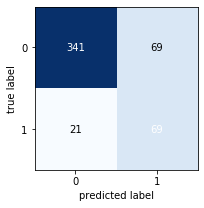

In [13]:
##Results on test data XP1'

from mlxtend.plotting import plot_confusion_matrix

from sklearn.metrics import confusion_matrix
y_pred = bestmodel.predict(X_test)

thresholders=[]  
for x in range(len(y_pred)):
  if y_pred[x][1]>0.5:   #define threshold range (optional)
    thresholders.append(1)
  else:
    thresholders.append(0)

thr_pred=np.asarray(thresholders)

y_pred = np.argmax(y_pred,axis = 1)
y_true = np.argmax(y_test, axis=1)

CM = confusion_matrix(y_true, y_pred)
fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(3, 3))
plt.show()

In [14]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.83      0.88       410
           1       0.50      0.77      0.61        90

    accuracy                           0.82       500
   macro avg       0.72      0.80      0.74       500
weighted avg       0.86      0.82      0.83       500



MODEL 2 PERFORMANCE ON TEST SET XP2

In [0]:
#load the test arrays and labels
X_test=np.load('/content/drive/My Drive/identify_pneumonia-master/colab_Data/x_test_child_200.npy')
y_test=np.load('/content/drive/My Drive/identify_pneumonia-master/colab_Data/y_test_child_200.npy')

In [0]:
##reshape if there is an error on input shape
X_test=X_test.reshape(624,200,200,3)

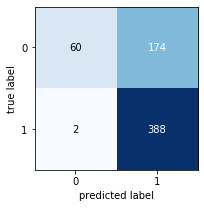

In [17]:
##Results on test data XP2

from mlxtend.plotting import plot_confusion_matrix

from sklearn.metrics import confusion_matrix
y_pred = bestmodel.predict(X_test)

thresholders=[]  
for x in range(len(y_pred)):
  if y_pred[x][1]>0.5:   #define threshold range (optional)
    thresholders.append(1)
  else:
    thresholders.append(0)

thr_pred=np.asarray(thresholders)

y_pred = np.argmax(y_pred,axis = 1)
y_true = np.argmax(y_test, axis=1)

CM = confusion_matrix(y_true, y_pred)
fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(3, 3))
plt.show()

In [18]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.26      0.41       234
           1       0.69      0.99      0.82       390

    accuracy                           0.72       624
   macro avg       0.83      0.63      0.61       624
weighted avg       0.79      0.72      0.66       624

